http://actionrecognition.net/files/dsetdetail.php?did=15;
https://github.com/epic-kitchens/annotations

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, EPIC_KITCHENS_DIR
import urllib.request

In [12]:
import pandas as pd

In [13]:
actions_data = pd.read_csv(EPIC_KITCHENS_DIR / 'EPIC_train_action_labels.csv')

In [14]:
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [15]:
actions = [actions_data[actions_data.video_id == vid].verb_class.values for vid in tqdm(actions_data.video_id.unique())]

In [16]:
actions_name = [[actions_data[actions_data.video_id == vid].verb.values, actions_data[actions_data.video_id == vid].noun.values] for vid in tqdm(actions_data.video_id.unique())]

In [18]:
behav_lens = [len(i) for i in actions]

In [19]:
import matplotlib.pyplot as plt

In [20]:
import numpy as np

In [21]:
np.sum(behav_lens)

28472

In [22]:
len(np.unique(np.concatenate(actions)))

119

In [23]:
np.median(behav_lens)

45.0

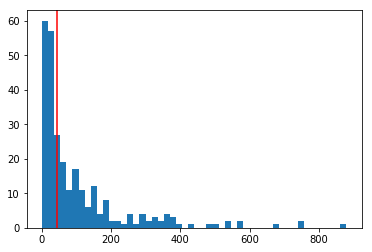

In [24]:
fig, ax = plt.subplots()
ax.hist(behav_lens, bins = 50);
ax.axvline(np.median(behav_lens), color='red')

### MI

In [25]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [38]:
distances = np.arange(1,250).astype('int')

In [39]:
actions_indv = [["{}_{}".format(bi, element) for element in bout] for bi, bout in enumerate(tqdm(actions))]

In [40]:
actions_indv[0][:10]

['0_2', '0_12', '0_3', '0_2', '0_0', '0_0', '0_0', '0_3', '0_2', '0_0']

In [41]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    np.array(actions_indv), distances=distances, n_jobs=-1, estimate=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.1s


[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    5.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    5.3s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done 136 out of 249 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    1.1s finished


In [42]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [43]:
MI_DF.to_pickle(DATA_DIR / "mi" / "epic_kitchens.pickle")

In [44]:
row = MI_DF.iloc[0]

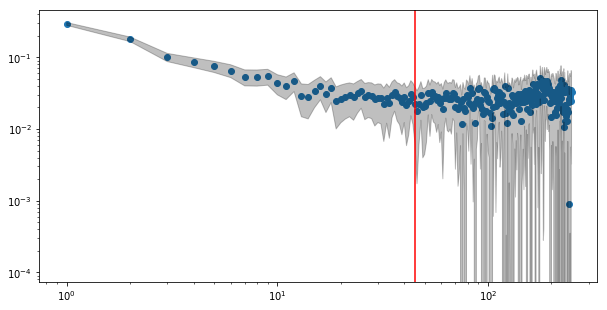

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
ax.axvline(np.median(behav_lens), color='red')
ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
#ax.set_ylim([1e-3, 1])
ax.set_yscale('log')
ax.set_xscale('log')

# NO REPEATS

In [65]:
from childes_mi.information_theory import model_fitting as mf

In [66]:
def remove_repeats(sequence):
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [67]:
actions_indv_no_repeats = [remove_repeats(i) for i in actions_indv]

In [71]:
distances = np.arange(1,np.median(behav_lens)+1).astype('int')
distances

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [72]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    np.array(actions_indv_no_repeats), distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  45 | elapsed:    3.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  45 | elapsed:    3.6s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  22 out of  45 | elapsed:    3.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    3.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  45 | elapsed:    0.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  12 out of  45 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  45 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.4s finished


In [73]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [75]:
MI_DF.to_pickle(DATA_DIR / "mi" / "epic_kitchens_mi_1000_no_repeats.pickle")

In [76]:
MI_DF[:10]

,MI,MI_var,shuff_MI,shuff_MI_var,distances
0,"[10.210136406710777, 10.021290569570946, 9.903...","[0.013827482590202772, 0.013783578882331459, 0...","[9.87213980925305, 9.850177988084107, 9.828890...","[0.013581954860203162, 0.013670418918087391, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [77]:
row = MI_DF.iloc[0]

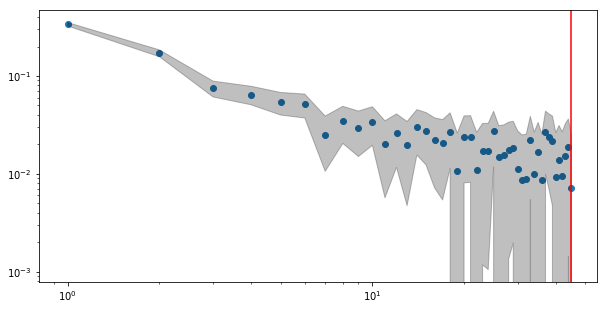

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
ax.axvline(np.median(behav_lens), color='red')
ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
#ax.set_ylim([1e-3, 1])
ax.set_yscale('log')
ax.set_xscale('log')

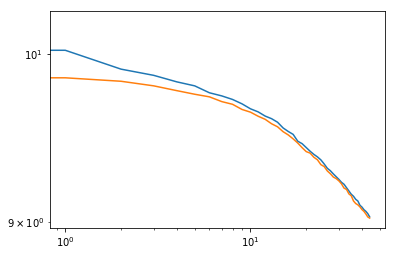

In [81]:
plt.loglog(row.MI)
plt.loglog(row.shuff_MI)

In [82]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [83]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]


In [94]:
MI_DF

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[10.210136406710777, 10.021290569570946, 9.903...","[0.013827482590202772, 0.013783578882331459, 0...","[9.87213980925305, 9.850177988084107, 9.828890...","[0.013581954860203162, 0.013670418918087391, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.951403,0.971385,0.970133,-176.019857,-194.90045,-197.927124,pow,"[5.619919749335576e-07, 8.445610658619456e-07,...",NaN


In [96]:
from matplotlib import gridspec

In [98]:
median_len = 45

In [101]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

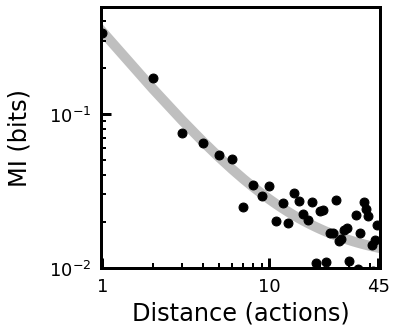

In [120]:
yoff=-.125
ncols = 4
zoom = 5
hr = [0.75, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(5, 15.5)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

row = MI_DF.iloc[0]
axi =0

color = 'k'#LCOL_DICT[row.language]
ax0 = plt.subplot(gs[0,axi])
ax = ax0
sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig

dist_mask = distances < median_len
distances = distances[dist_mask]
sig = sig[dist_mask]

# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

if axi==0: 
        ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(-.25,0.5)

# model data
#row.concat_results.params.intercept = 0
distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

# plot real data
ax.scatter(distances, sig, alpha = 1, s=80, color=color)   

# plot modelled data
ax.plot(distances, y_model, alpha = 0.25, lw=10, color=color)


ax.set_xlim([distances[0], distances[-1]])
sig_lims[0] = np.log(10e-6)
ax.set_ylim([1e-4, 3])
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)
ax.set_xscale( "log" , basex=10)
ax.set_yscale( "log" , basey=10)
ax.set_xticks([])
ax.set_xticks([1,10,45])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.set_ylim([1e-2, 0.5])
ax.set_xticks([1,10,45])
ax.set_xticklabels(['1','10','45'], fontsize=16)

if axi !=0:
    for ax in [ax0,ax1,ax2]:
        ax.yaxis.set_ticklabels([])

for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(18)        
       
gs.update(wspace=0.075, hspace=0.1)
ax.set_xlabel('Distance (actions)', labelpad=5, fontsize=24)

ax.set_xlim([0.98, 46])

save_fig(FIGURE_DIR/'epic_kitchens_mi_no-repeats')

In [103]:
labels = ['cooking-norepeat']

### Calculate R2

In [104]:
R2 = MI_DF[['R2_exp', 'R2_concat', 'R2_power']]
R2.columns = ['exp', 'combined', 'power-law']
R2.index = labels
R2 = R2.T
R2

,cooking-norepeat
exp,0.951403
combined,0.971385
power-law,0.970133


### AICc

In [105]:
AICcs = MI_DF[['AICc_exp', 'AICc_concat', 'AICc_power']]
AICcs.columns = ['exp', 'combined.', 'power-law']
AICcs.index = labels
AICcs = AICcs.T
AICcs

,cooking-norepeat
exp,-176.019857
combined.,-194.900450
power-law,-197.927124


#### $\Delta$AIC

In [106]:
delta_AICcs = AICcs.T - np.repeat(np.min(AICcs.T.values, axis=1),3).reshape(len(labels),3)
delta_AICcs = delta_AICcs.T
delta_AICcs

,cooking-norepeat
exp,21.907268
combined.,3.026674
power-law,0.000000


### relative likelihood

In [107]:
relative_likelihoods = mf.relative_likelihood(delta_AICcs)
relative_likelihoods

,cooking-norepeat
exp,0.000017
combined.,0.220174
power-law,1.000000


### relative probability of models

In [108]:
prob_models = mf.Prob_model_Given_data_and_models(relative_likelihoods)
prob_models

,cooking-norepeat
exp,0.000014
combined.,0.180442
power-law,0.819543


#### Join tables

In [109]:
AICcs['superlabel'] = 'AICc'
relative_likelihoods['superlabel'] = 'Relative likelihood'
R2['superlabel'] = '$r^2$'
prob_models['superlabel'] = 'Relative probability'

In [110]:
results_table = pd.concat([
    AICcs,
    R2,
    relative_likelihoods,
    prob_models
]).round(3).replace(0, '<0.001').replace(1, '>0.999')
results_table[''] = results_table.index
results_table.set_index(['superlabel', ''], inplace=True)
results_table

cooking-norepeat
superlabel                                     
AICc                 exp                -176.02
                     combined.           -194.9
                     power-law         -197.927
$r^2$                exp                  0.951
                     combined             0.971
                     power-law             0.97
Relative likelihood  exp                 <0.001
                     combined.             0.22
                     power-law           >0.999
Relative probability exp                 <0.001
                     combined.             0.18
                     power-law             0.82

In [111]:
results_string = results_table.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)

\begin{tabular}{lll}
\toprule
                     &           & cooking-norepeat \\
\midrule
\textbf{} & {} &                  \\
\midrule
\midrule
\textbf{AICc} & \textbf{exp} &          -176.02 \\
                     & \textbf{combined.} &           -194.9 \\
                     & \textbf{power-law} &         -197.927 \\
\midrule
\textbf{$r^2$} & \textbf{exp} &            0.951 \\
                     & \textbf{combined} &            0.971 \\
                     & \textbf{power-law} &             0.97 \\
\midrule
\textbf{Relative likelihood} & \textbf{exp} &           $<$0.001 \\
                     & \textbf{combined.} &             0.22 \\
                     & \textbf{power-law} &           $>$0.999 \\
\midrule
\textbf{Relative probability} & \textbf{exp} &           $<$0.001 \\
                     & \textbf{combined.} &             0.18 \\
                     & \textbf{power-law} &             0.82 \\
\bottomrule
\end{tabular}

